In [1]:
import numpy as np
from library_dicom.dicom_processor.tools.create_mip import *
import matplotlib.pyplot as plt
#from radiomics.featureextractor import *
from sklearn import mixture
import SimpleITK as sitk

from library_dicom.post_processing.PostProcess_Reader import PostProcess_Reader
from library_dicom.post_processing.Mask4D import Mask4D
from library_dicom.post_processing.WatershedModel import WatershedModel 
from library_dicom.dicom_processor.tools.folders import *
from library_dicom.dicom_processor.tools.threshold_mask import *
from library_dicom.dicom_processor.tools.postprocessing import *
import csv

In [2]:
#predictions 

pred_1 = os.listdir('/media/deeplearning/Elements/train')
pred_2 = os.listdir('/media/deeplearning/Elements/val')

pred = pred_1 + pred_2

study_uid = []

for item in pred_1 : 
    subliste = []
    subliste.append(item.split('_')[0]) 
    subliste.append('train')
    study_uid.append(subliste)

for item in pred_2 : 
    subliste = []
    subliste.append(item.split('_')[0]) 
    subliste.append('val')
    study_uid.append(subliste)


#charger csv agl, gained, flip 
csv_ahl=  '/media/deeplearning/Elements/AHL2011_NIFTI.csv'

with open(csv_ahl, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    data_ahl = []
    for row in reader :
        data_ahl.append(row)
        
del data_ahl[0] #enlever première ligne
 




csv_gained= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/GAINED_PET0_NIFTI.csv'

with open(csv_gained, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    data_gained = []
    for row in reader :
        data_gained.append(row)
        
del data_gained[0] #enlever première ligne



csv_flip= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/FLIP_NIFTI/FLIP_PET0_NIFTI.csv'

with open(csv_flip, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    data_flip = []
    for row in reader :
        data_flip.append(row)
        
del data_flip[0] #enlever première ligne

In [3]:
len(study_uid)

1005

In [4]:
study_uid[0]

['1.2.276.0.7230010.3.2.138382', 'train']

In [5]:
#find associated serie nifti 
dataset = []
for item in study_uid : 
    subliste = []
    subliste.append(item[0])
    subliste.append(item[1])
    for ahl in data_ahl : 
        if item[0] in ahl : 
            subliste.append(ahl[1]) #patient id 
            subliste.append(ahl[5]) #pet
            subliste.append(ahl[6]) #mask
            subliste.append('AHL')
            dataset.append(subliste)
        
    for gained in data_gained : 
        if item[0] in gained : 
            subliste.append(gained[0]) #patient id 
            subliste.append(gained[4]) #pet
            subliste.append(gained[5]) #mask 
            subliste.append('GAINED')
            dataset.append(subliste)

    for flip in data_flip : 
        if item[0] in flip : 
            subliste.append(flip[1]) #patient id 
            subliste.append(flip[5]) #pet
            subliste.append(flip[6]) #mask 
            subliste.append('FLIP')
            dataset.append(subliste)


In [6]:
len(dataset)

1005

In [7]:
dataset[0]

['1.2.276.0.7230010.3.2.138382',
 'train',
 '13011101031031',
 '/media/storage/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_PT.nii',
 '/media/storage/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_mask.nii',
 'AHL']

In [8]:
#include prediction 
for serie in dataset : 
    for prediction in pred :
        if serie[0] in prediction : 
            serie.append(prediction)
            break

In [9]:
dataset[0]

['1.2.276.0.7230010.3.2.138382',
 'train',
 '13011101031031',
 '/media/storage/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_PT.nii',
 '/media/storage/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_mask.nii',
 'AHL',
 '1.2.276.0.7230010.3.2.138382_mask_pred_float.nii']

In [8]:
for serie in dataset : 
    if len(serie) != 7 : 
        print(serie)

In [10]:
#rewrite path for ahl and relative path for pred
for serie in dataset : 
    if 'AHL' in serie : 
        txt = serie[3].replace('storage', 'deeplearning/Elements')
        serie[3] = txt 

        txt_2 = serie[4].replace('storage', 'deeplearning/Elements')
        serie[4] = txt_2 

    if 'train' in serie : 
        path = '/media/deeplearning/Elements'+'/'+'train'+'/'+serie[-1]
        serie[-1] = path 

    else : 
        path = '/media/deeplearning/Elements'+'/'+'val'+'/'+serie[-1]
        serie[-1] = path 



In [11]:
dataset[0]

['1.2.276.0.7230010.3.2.138382',
 'train',
 '13011101031031',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_PT.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_mask.nii',
 'AHL',
 '/media/deeplearning/Elements/train/1.2.276.0.7230010.3.2.138382_mask_pred_float.nii']

In [12]:
#write csv 
nifti_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/pred_2'

with open(os.path.join(nifti_directory, 'dataset_post_processing_pred2.csv'), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "NIFTI_PET", "NIFTI_MASK", "PRED_MASK", "TYPE", "STUDY"])
    for serie in dataset:
        csv_writer.writerow([serie[2], serie[0], serie[3], serie[4], serie[6], serie[1], serie[5]])  

In [13]:
#read csv 
csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/pred_2/dataset_post_processing_pred2.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    dataset = []
    for row in reader :
        dataset.append(row)
        
del dataset[0] #enlever première ligne

In [14]:
dataset[0]

['13011101031031',
 '1.2.276.0.7230010.3.2.138382',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_PT.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.276.0.7230010.3.2.138382_nifti_mask.nii',
 '/media/deeplearning/Elements/train/1.2.276.0.7230010.3.2.138382_mask_pred_float.nii',
 'train',
 'AHL']

In [15]:
results_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/pred_2'
error = []
#path_mip = []


for serie in dataset: 
    print(dataset.index(serie))
    subliste = []
    try : 
        model = WatershedModel(serie[4], serie[2], type = '3d')
        ws_array, label_number = model.watershed_model(0.5)

        #folder = results_directory+'/'+serie[1]
        #if not os.path.exists(folder):
         #   os.makedirs(folder) 


        #angle_filename_mask = mip_projection(ws_array, 90, folder, serie[1], type ='mask', cmap='viridis', vmin = None, vmax = None)
        #print("MIP MASK 90")
        #subliste.append(angle_filename_mask)
        #suv_values_array = model.get_pet_view(model.pet_array, ws_array)
        #angle_filename_pet = mip_projection(suv_values_array, 90, folder, serie[1], type='pet', cmap='Greys', vmin = 3, vmax = 10 )
        #subliste.append(angle_filename_pet)
        #print("MIP PET 90")
        #subliste.append(serie[1])
        #subliste.append(label_number)
        #path_mip.append(subliste)

        #other_angle = []
        #angle_filename_mask_0 = mip_projection(ws_array, 0, folder, serie[1], type ='mask', cmap='viridis', vmin = None, vmax = None)
        #other_angle.append(angle_filename_mask_0)
        #print("MIP MASK 0")
        #angle_filename_pet_0 = mip_projection(suv_values_array, 0, folder, serie[1], type='pet', cmap='Greys', vmin = 3, vmax = 10 )

        #other_angle.append(angle_filename_pet_0)
        #print("MIP PET 0")
        #other_angle.append(serie[1])
        #other_angle.append(label_number)
        #path_mip.append(other_angle)

        volume_voxel = model.pet_spacing[0]*model.pet_spacing[1]*model.pet_spacing[2]*10**(-3)


         #VOLUME PREDICTION AVEC WATERSHED AFTER SEUIL 41%

        ws_array = get_threshold_matrix(ws_array, model.pet_array, label_number, 0.41)
        
        number_pixel = len(np.where(ws_array != 0)[0])
        vol_sous_seg_seuil = number_pixel * volume_voxel
        serie.append(vol_sous_seg_seuil)
        #tmtv.append(vol_sous_seg_seuil)
        print("VOL WITH WATERSHED OK")


        #VOLUME LABELLED FIRST TIME WITHOUT WATERSHED 
        binary_img = model.get_binary_threshold_mask_img(0.5)
        binary_array = model.remove_small_roi(binary_img)

        number_pixel_binaire = len(np.where(binary_array != 0 )[0])
        vol_binaire = number_pixel_binaire * volume_voxel 
        serie.append(vol_binaire)
        print("VOL PRED OK ")

        #VOLUME TRUTH SEUIL 41%

        img_4d = sitk.ReadImage(serie[3])
        mask = sitk.GetArrayFromImage(img_4d).transpose()
        mask = get_threshold_matrix_4D(mask, model.pet_array, 0.41)

        if len(mask.shape) != 3 : 
            mask_sum = np.sum(mask, axis = -1)
        else : 
            mask_sum = mask 

        number_pixel_truth = len(np.where(mask_sum != 0)[0])

        vol_truth = number_pixel_truth * volume_voxel

        serie.append(vol_truth) 

        print("VOL TRUTH OK ")

        #img = sitk.GetImageFromArray(ws_array)
        #img2 = sitk.GetImageFromArray(ws_array.transpose())
        #img.SetDirection(model.pet_direction)
        #img.SetOrigin(model.pet_origin)
        #img.SetSpacing(model.pet_spacing)
        #img2.SetDirection(model.pet_direction)
        #img2.SetOrigin(model.pet_origin)
        #img2.SetSpacing(model.pet_spacing)
        #filename = folder+'/'+serie[1]+'_nifti_mask.nii'
        #sitk.WriteImage(img, filename)

        #json_details = model.label_stat_results(img2)
        #tmtv.append(json_details['total_vol'])
        #write_json_file(folder, serie[1]+'_details', json_details)


        #tmtv binary 

        #binary_array = model.get_binary_threshold_mask_array(0.5)


        #binary_array = get_threshold_matrix(binary_array, model.pet_array, 1, 0.41)

        #pixel_volume = model.pet_spacing[0]*model.pet_spacing[1]*model.pet_spacing[2] * 10**(-3) 
        #number_pixel = len(np.where(binary_array != 0)[0])
    
        #tmtv_binary.append(pixel_volume * number_pixel)


    except Exception as err : 
        print(err)
        print(serie)
        error.append(serie)

VOL TRUTH OK 
628
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
629
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
630
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
631
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
632
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
633
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
634
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
635
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
636
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
637
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
638
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
639
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
640
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
641
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
642
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
643
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
644
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
645
VOL WITH WATERSHED OK
VOL PRED OK 
VOL TRUTH OK 
646
VOL WITH WATERSHED OK
VOL PR

In [16]:
#write csv 
nifti_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/pred_2'

with open(os.path.join(nifti_directory, 'result_tmtv_sous_seg.csv'), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "NIFTI_PET", "NIFTI_MASK", "PRED_MASK", "TYPE", "STUDY", "VOL_TRUTH", "VOL_PRED", "VOL_WS"])
    for serie in dataset:
        csv_writer.writerow([serie[0], serie[1], serie[2], serie[3], serie[4], serie[5], serie[6], serie[-1], serie[-2], serie[-3]])  

In [ ]:
csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/diff_tmtv_truth_pred.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data = []
    for row in reader :
        csv_data.append(row)
        
del csv_data[0] #enlever première ligne

In [46]:
#calcul volume_pred : 
volume_pred = []
for serie in csv_data : 
    print(csv_data.index(serie))

    model = WatershedModel(serie[3], serie[2], '3d')
    binary_img = model.get_binary_threshold_mask_img(0.5)
    binary_array = model.remove_small_roi(binary_img)

    volume_voxel = model.pet_spacing[0]*model.pet_spacing[1]*model.pet_spacing[2]*10**(-3)
    number_pixel = len(np.where(binary_array != 0)[0])

    volume_pred.append(volume_voxel * number_pixel)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [47]:
write_json_file('/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing', 'volume_predi', volume_pred)

In [11]:
#calcul volume truth
tmtv_truth_41 = []
for serie in csv_data : 
    print(csv_data.index(serie))
    mask_img = sitk.ReadImage(serie[4])
    mask_array = sitk.GetArrayFromImage(mask_img).transpose()
    #mip_imshow(mask_array, 0, cmap='viridis', type='mask', vmin=None, vmax= None)
    pet_img = sitk.ReadImage(serie[2])
    pet_array = sitk.GetArrayFromImage(pet_img).transpose()

    spacing = pet_img.GetSpacing()
    volume_voxel = spacing[0]*spacing[1]*spacing[2]* 10**(-3)

    mask_array = get_threshold_matrix_4D(mask_array, pet_array, 0.41)

    if len(mask_array.shape) != 3 : 
        mask_array = np.sum(mask_array, axis = -1)


    number_pixel = len(np.where(mask_array != 0)[0])
    vol = volume_voxel * number_pixel
    tmtv_truth_41.append(vol)
    #mip_imshow(mask_array, 0, cmap='viridis', type='mask', vmin=None, vmax= None)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
write_json_file('/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing', 'tmtv_verite_terrain', tmtv_truth_41)

In [ ]:
#reste à différencier les pred qui ont un tmtv au dessus du tmtv truth, 
#appliquer watershed
#voir résultas 

#va faire pareil avec les preds qui ont un tmtv en dessous du tmtv truth

In [13]:
csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/diff_tmtv_truth_pred.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data = []
    for row in reader :
        csv_data.append(row)
        
del csv_data[0] #enlever première ligne

In [14]:
json_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/tmtv_verite_terrain.json'
tmtv_truth = []
with open(json_path) as json_file : 
    reader = json.load(json_file)
    for info in reader :
        tmtv_truth.append(info)

print(len(tmtv_truth))

404


In [15]:
json_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/volume_predi.json'
tmtv_pred = []
with open(json_path) as json_file : 
    reader = json.load(json_file)
    for info in reader :
        tmtv_pred.append(info)

print(len(tmtv_pred))

404


In [16]:
dataset_1 = []
dataset_2 = []
for item in tmtv_truth : 
    index = tmtv_truth.index(item)
    if tmtv_pred[index] >= item : 
        dataset_1.append(csv_data[index])

    if tmtv_pred[index] <= item : 
        dataset_2.append(csv_data[index])
    


In [17]:
print(len(dataset_1))
print(len(dataset_2))

182
222


In [18]:
write_json_file('/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing', 'dataset_1', dataset_1)
write_json_file('/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing', 'dataset_2', dataset_2)

In [ ]:
#CALCUL TMTV SOUS SEG 

In [20]:
len(tmtv)

182

In [21]:
pourcent = []
for i in range(len(tmtv)):
    index = csv_data.index(dataset[i])
    #print(index)
    diff = (abs(tmtv_truth[index] - tmtv[i]) / tmtv_truth[index]) * 100
    pourcent.append(diff)

In [23]:
cpt = 0
for item in pourcent : 
    if item <= float(35) : 
        cpt += 1 
cpt

152

In [24]:
nifti_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing'

with open(os.path.join(nifti_directory, 'ahl_tmtv_watershed_result.csv'), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "NIFTI_PET", "PRED_MASK", "NIFTI_MASK", "CSV", "VOL_TRUTH", "VOL_PRED", "VOL_WS","POURCENT_WS"])
    for serie in dataset:
        index = csv_data.index(serie)
        index_2 = dataset.index(serie)
        csv_writer.writerow([serie[0], serie[1], serie[2], serie[3], serie[4], serie[5], tmtv_truth[index], tmtv_pred[index], tmtv[index_2], pourcent[index_2]])  

In [9]:
#mask binaire 

In [45]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'vol_binary')

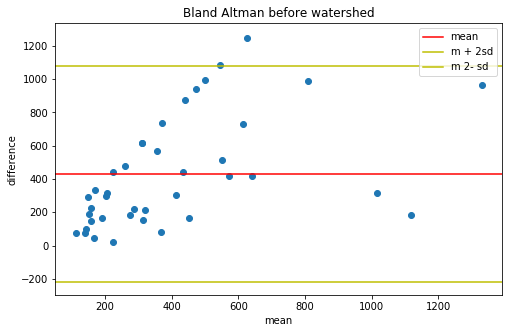

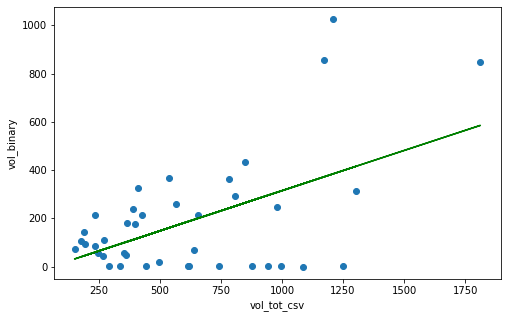

In [61]:
diff = []
moyenne = []
for i in range(len(vol_total_csv)) :
    diff.append(float(vol_total_csv[i]) - float(vol_binaire[i]))
    subliste = []
    subliste.append(float(vol_total_csv[i]))
    subliste.append(float(vol_binaire[i]))
    moyenne.append(np.mean(subliste))

f = plt.figure(figsize=(8,5))
axes = plt.gca()
mean = np.mean(diff)
sd = np.std(diff)
plt.axhline(mean, c = 'r', label = 'mean')
plt.axhline(mean + 2 * sd, c='y', label='m + 2sd')
plt.axhline(mean - 2 * sd, c='y', label='m 2- sd')
plt.scatter(moyenne, diff)
plt.xlabel("mean")
plt.ylabel('difference')
plt.legend()
plt.title("Bland Altman before watershed")


from scipy import stats
#linregress() renvoie plusieurs variables de retour. On s'interessera 
# particulierement au slope et intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(vol_total_csv, vol_binaire)

def regression(x, slope, intercept):
    y = []
    for i in range(len(x)):
        y.append(slope * x[i] + intercept)

    return y 

f = plt.figure(figsize=(8,5))
axes = plt.gca()
plt.scatter(vol_total_csv, vol_binaire)
plt.plot(vol_total_csv, regression(vol_total_csv, slope, intercept), c='green')
plt.xlabel('vol_tot_csv')
plt.ylabel('vol_binary')



Text(0, 0.5, 'vol_binary')

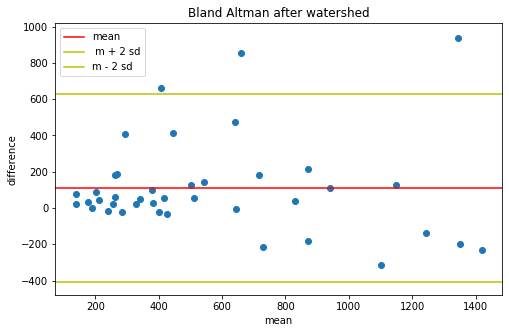

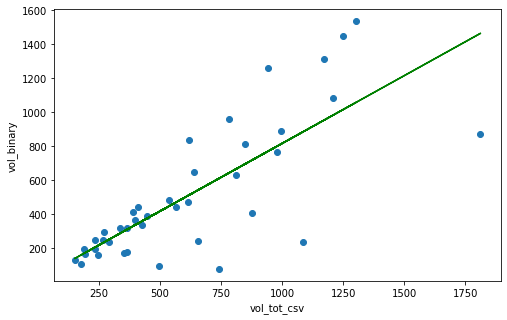

In [71]:
#tmtv sous seg 
diff = []
moyenne = []
for i in range(len(vol_total_csv)) :
    diff.append(float(vol_total_csv[i]) - float(vol_sous_seg[i]))
    subliste = []
    subliste.append(float(vol_total_csv[i]))
    subliste.append(float(vol_sous_seg[i]))
    moyenne.append(np.mean(subliste))

f = plt.figure(figsize=(8,5))
axes = plt.gca()
mean = np.mean(diff)
sd = np.std(diff)
plt.axhline(mean, c = 'r', label = 'mean')
plt.axhline( mean + 2 *sd, c='y',  label=' m + 2 sd')
plt.axhline(mean - 2 *sd, c='y', label='m - 2 sd')
plt.scatter(moyenne, diff)
plt.xlabel("mean")
plt.ylabel('difference')
plt.legend()
plt.title("Bland Altman after watershed")




from scipy import stats
#linregress() renvoie plusieurs variables de retour. On s'interessera 
# particulierement au slope et intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(vol_total_csv, vol_sous_seg)

def regression(x, slope, intercept):
    y = []
    for i in range(len(x)):
        y.append(slope * x[i] + intercept)

    return y 

f = plt.figure(figsize=(8,5))
axes = plt.gca()
plt.scatter(vol_total_csv, vol_sous_seg)
plt.plot(vol_total_csv, regression(vol_total_csv, slope, intercept), c='green')
plt.xlabel('vol_tot_csv')
plt.ylabel('vol_binary')
